In [1]:
#pip install tensorflow

In [2]:
#pip install xgboost

In [3]:
#pip install prettytable

In [4]:
#pip install hyperas

In [5]:
# Importing the necessary lib
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer,one_hot
#from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,MaxPool2D,Embedding,Dense,Dropout,MaxPooling2D,Reshape,BatchNormalization
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,f1_score,log_loss,recall_score,classification_report

# train-test
from sklearn.model_selection import train_test_split


import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
from time import time
from scipy.sparse import hstack
from tensorflow.python.keras.callbacks import TensorBoard
import pickle
from keras.optimizers import Adam,SGD,RMSprop
from keras.initializers import RandomUniform,he_uniform,glorot_normal
from keras.regularizers import l1
from keras.models import Sequential
from keras.layers import LSTM,BatchNormalization
from keras.layers.core import Dense, Dropout
import datetime
from prettytable import PrettyTable
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform,pchoice
from keras.utils import to_categorical
from keras.regularizers import l1
# warnings
import warnings
warnings.filterwarnings("ignore")

print("All modules loaded")

All modules loaded


In [6]:
# concatenate dataframes with faulty and fault free instances
df1 = pd.read_csv('faulty.csv')
df2 = pd.read_csv('fault_free.csv')
df = pd.concat([df1, df2])

In [7]:
# remove rows with Missing Values 
df = df.dropna(axis=0)

In [8]:
# reduce the size by random sampling (the dataset too large to analyse on a normal PC)
df_reduced = df.sample(frac = .001)

In [9]:
df_reduced.size

87416

In [10]:
# Split dataframe randomly into train and test dataframes
seed = 1 # for reproducable results
train = df_reduced.sample(frac = 0.8)
test = df.drop(train.index)

In [11]:
train.head(10)

,Unnamed: 0,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
87527,87528,12,5,168,0.27363,3661.2,4480.6,9.5330,26.924,42.551,...,54.154,27.087,62.861,22.565,40.552,39.518,47.808,46.082,40.831,17.883
652464,652465,20,34,625,0.29332,3663.6,4527.5,9.3707,27.363,41.818,...,54.092,28.718,61.366,21.720,38.297,39.163,47.922,46.733,41.331,16.336
161302,161303,9,9,23,0.25248,3680.1,4475.7,9.3469,26.977,42.135,...,53.758,24.584,61.530,22.090,41.557,32.584,48.604,47.586,41.372,18.337
421896,421897,0,440,457,0.24583,3699.9,4466.0,9.5890,27.115,42.175,...,53.562,24.286,62.133,22.591,40.240,40.287,41.732,48.081,41.397,19.046
205879,205880,15,11,440,0.28743,3701.9,4568.9,9.3277,26.378,42.404,...,54.498,28.681,60.401,21.913,38.866,35.141,51.928,45.076,41.280,17.797
1062250,1062251,7,56,491,0.22900,3668.1,4477.9,9.2880,27.036,42.304,...,54.146,22.271,77.517,23.720,39.069,38.120,45.126,54.965,40.857,18.091
835301,835302,11,44,102,0.23969,3637.5,4522.7,9.2595,26.968,42.318,...,53.991,23.352,64.076,23.042,40.852,40.016,49.386,47.999,41.276,18.018
1019999,1020000,3,54,480,0.22017,3660.8,4513.9,9.2372,27.134,42.423,...,53.653,21.168,62.432,21.694,38.258,36.748,47.441,39.323,41.371,18.794
212969,212970,2,12,810,0.26738,3738.7,4670.8,9.5416,26.858,42.441,...,56.384,26.201,63.050,21.838,80.717,40.653,44.040,19.615,42.158,14.889
322999,323000,0,337,440,0.23388,3645.8,4560.8,9.3203,27.030,42.191,...,53.454,23.147,59.590,22.918,37.533,41.623,46.065,46.736,41.507,18.318


In [12]:
#Sorting the Datasets wrt to the simulation runs
train.sort_values(['simulationRun','faultNumber'],inplace = True)
test.sort_values(['simulationRun','faultNumber'],inplace = True)

In [13]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1,2,4,5,6,7,8,10,11,12,13,14,16,17,18,19,20]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(25,25))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(25,25))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(25,25))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [14]:
# Removing faults 22 
tr = train.drop(train[(train.faultNumber == 22)].index).reset_index()
ts = test.drop(test[(test.faultNumber == 22)].index).reset_index()

In [15]:
#converting the class labels to categorical values and removing unnecessary features from train, test data.
y_train = pd.Categorical(tr['faultNumber'])
y_test = pd.Categorical(ts['faultNumber'])
tr.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis=1,inplace=True)
ts.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis =1,inplace=True)

In [16]:
# normalise the data
standard_scalar = StandardScaler()
train_norm = standard_scalar.fit_transform(tr)
test_norm = standard_scalar.transform(ts)

In [17]:
# model fitting and hyperparameter tunning using gridsearch
x_cfl=xgb.XGBClassifier(objective="multi:softprob")

prams={
    
     'n_estimators':[100,200,500],
     'max_depth':[5,10,15,20,30,35]
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1_micro',cv=3)
model.fit(train_norm,y_train)
print("Best estimator is", model.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best estimator is {'max_depth': 20, 'n_estimators': 100}


In [18]:
clf=xgb.XGBClassifier(objective="multi:softprob",n_estimators=100,max_depth=5,n_jobs=-1)
clf.fit(train_norm, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Number of misclassified points  40.47479907190432
-------------------------------------------------- Confusion matrix --------------------------------------------------


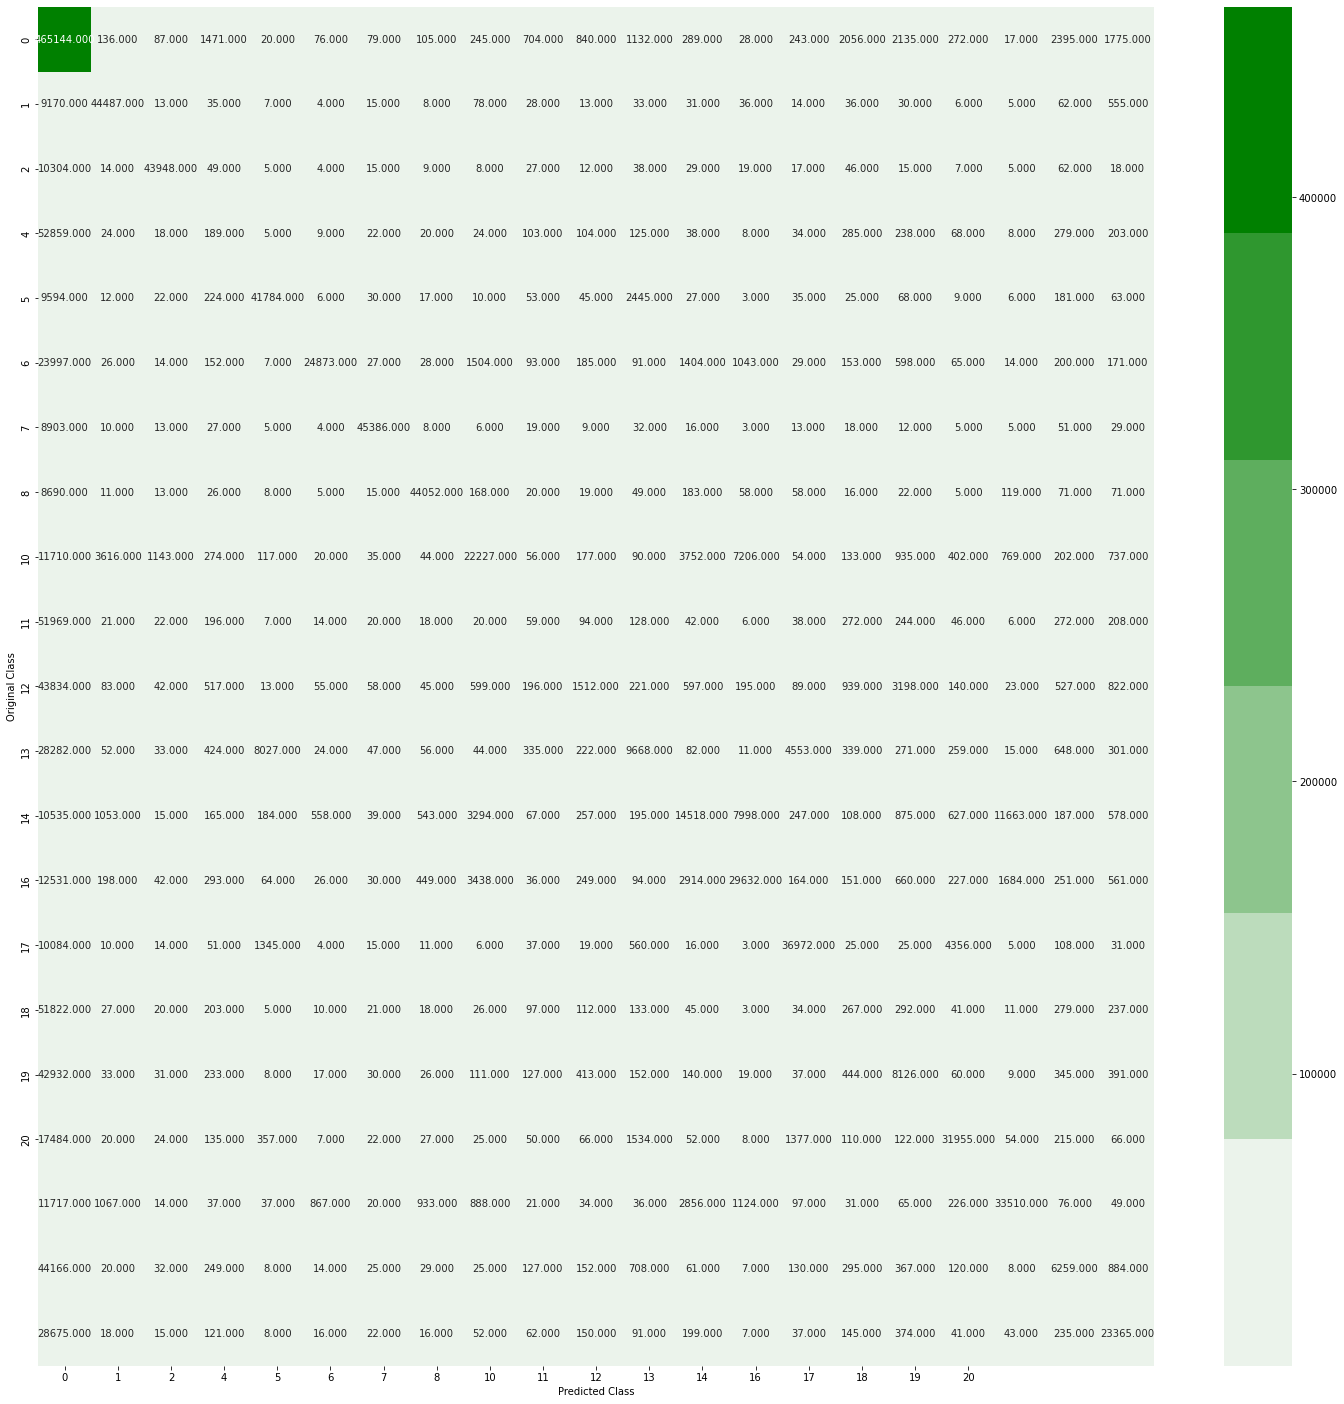

-------------------------------------------------- Precision matrix --------------------------------------------------


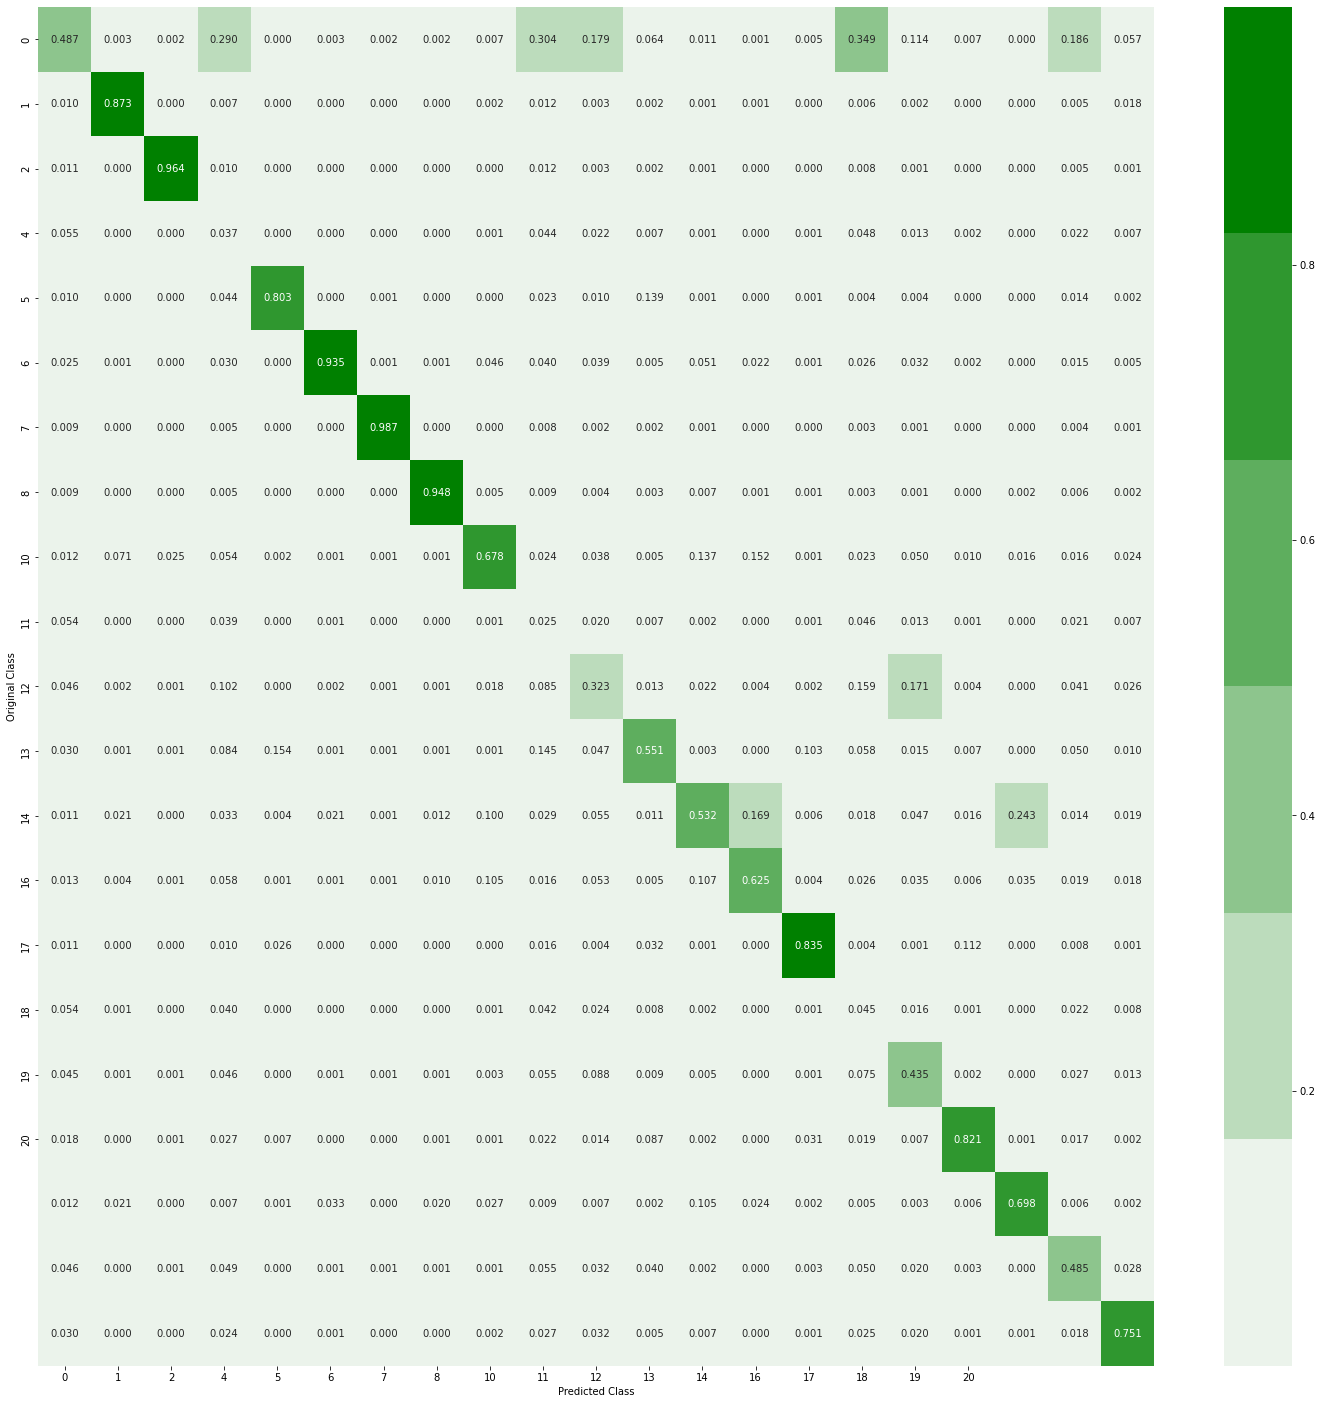

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


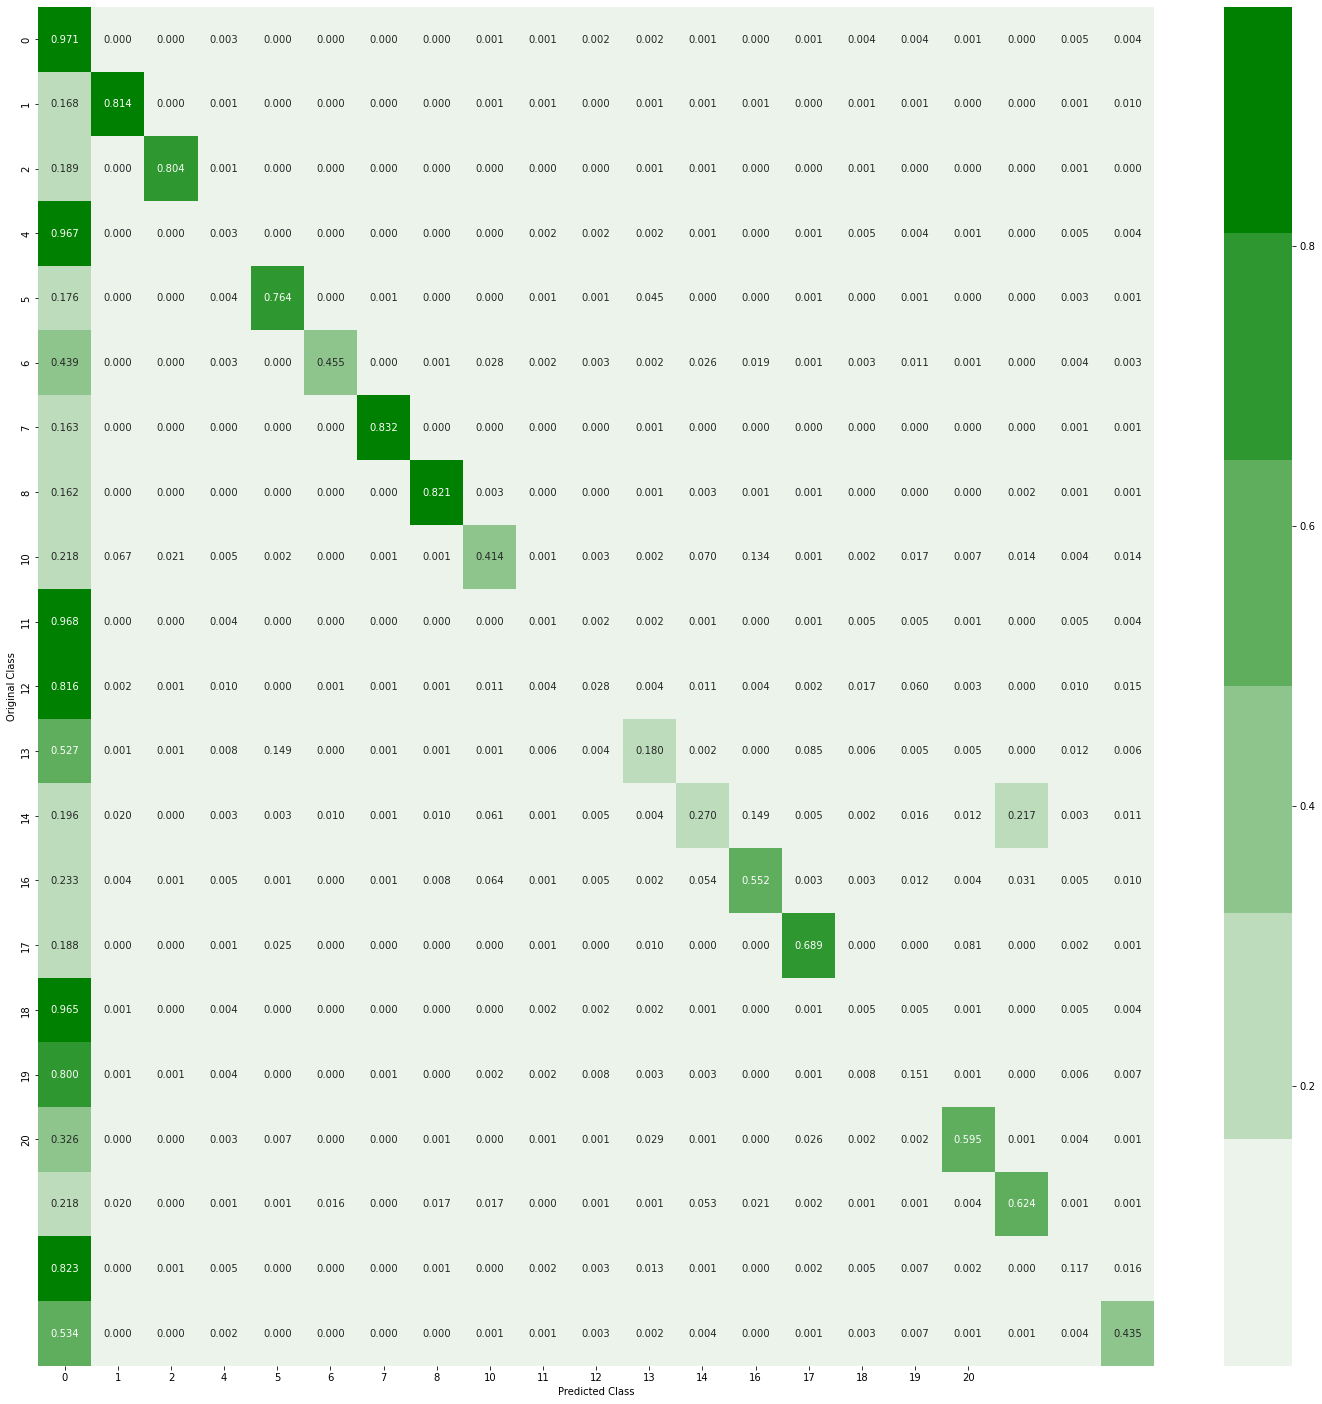

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [19]:
# predictions
y_pred_test = clf.predict(test_norm)
plot_confusion_matrix(y_test, y_pred_test)

In [20]:
# Print
table = PrettyTable()
table.field_names = ['Model', 'Average FDR']
table.add_row(['XgBoost', 0.68])
print(table)

+---------+-------------+
|  Model  | Average FDR |
+---------+-------------+
| XgBoost |     0.68    |
+---------+-------------+


### Performance

Xgboot results in an FDR of 0.68 which is quite acceptable given the reduction of the dataset. We expect far better results if a larger sample can be admitted. Here, due to limited computing resources, only a relatively small dataset can be processed.

### Conclusion

The original datasets containing faulty and fault free instances, respectively, are concatenated. Then, a dataframe of reduced size is produced by sampling randomly the original concatenated dataset. Then, the working dataframe is further reduced by trancating rows with missing values. The produced dataframe is split into a training and testing set. We select the XGBClassifier as a classification model the hyperparameters of which are tuned via grid search for simplicity. The model performs relatively well resulting in an FDR of 0.68. This score can easily be improved by considering larger samples. The code can readily be ammended with other classifiers such as Random Forest for comparison.
